In [4]:
import re
import numpy as np
import sympy as sp
from collections import OrderedDict as odict
from collections import namedtuple as ntuple
from functools import reduce
from itertools import product
%load_ext autoreload
%autoreload 2
import tensorops as to
from notation import *
# from functools import lru_cache
import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
cfps_folder = '/Users/juan/cfps'

# named tuples
State = ntuple('State',['seniority','sup_irrep'])
Term = ntuple('Term',['S','L','W'])
CFP = ntuple('CFP',['daughter', 'parent'])
Config = ntuple('config',['l','n'])

primes = [2,3,5,7,11,13,17,19,23,29,31]
primes = list(map(sp.S, primes))

# One body CFPS

In [155]:
def prime_parser(string_rep):
    for rep, repnum in zip(['A', 'B', 'C', 'D'],['10','11','12','13']):
        string_rep = string_rep.replace(rep, repnum)
    num_rep = list(map(int, string_rep.split(' ')))
    a0 = num_rep[0]
    if len(num_rep) == 1:
        num_rep = a0
    else:
        tail = sp.sqrt(reduce(sp.core.mul.Mul,[p**a for p,a in zip(primes,num_rep[1:]) if a!=0]))
        num_rep = a0*tail
    return num_rep
def clarify_rep(string_rep):
    for rep, repnum in zip(['A', 'B', 'C', 'D'],['10','11','12','13']):
        string_rep = string_rep.replace(rep, repnum)
    return string_rep

In [231]:
all_cfps = odict()
all_cfps_prime = odict()
clear_text_sprime = ['l n daughter parent cfp_sqrt_prime_notation']
clear_text_float = ['l n daughter parent cfp_float']
all_nums = []
for l in [1,2,3]:
    fname = os.path.join(cfps_folder,'B1%s_ALL.txt' % l_notation_switch(l).upper())
    lines = open(fname,'r').read().split('\n')
    cfps = odict()
    cfps_prime = odict()
    for line in lines:
        oline = line
        if line == '':
            continue
        if line[0] == '[':
            sector = line.split(']')[0][-2:]
            sector = Config(l_notation_switch(sector[0]),int(sector[1]))
            cfps[sector] = odict()
            cfps_prime[sector] = odict()
            continue
        if '[DAUGHTER TERM]' in line:
            dau = line.split('[')[0]
            assert len(dau) <= 4
            if not dau[-1].isdigit():
                W_dau = 1
            else:
                W_dau = int(dau[2:])
            L_dau, SMulti_dau =  l_notation_switch(dau[1]), int(dau[0])
            S_dau = sp.S(SMulti_dau-1)/2
            term_dau = Term(S_dau, L_dau, W_dau)
        else:
            line = line.replace('-',' -')
            rline = re.sub(' +', ' ', line.strip())
            rline = rline.split(' ')
            parent = rline[0]
            assert len(parent) <= 4
            if not parent[-1].isdigit():
                W_par = 1
            else:
                W_par = int(parent[2:])
            L_par, SMulti_par = l_notation_switch(parent[1]), int(parent[0])
            S_par = sp.S(SMulti_par-1)/2
            term_par = Term(S_par, L_par, W_par)
            cfp = ' '.join(rline[2:])
            cfp_num = prime_parser(cfp)
            cfps[sector][CFP(term_dau,term_par)] = cfp_num
            cfp_clear = clarify_rep(cfp)
            cfps_prime[sector][CFP(term_dau,term_par)] = cfp_clear
            clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
                        '%d%s%s' % (2*term_par.S+1, l_notation_switch(term_par.L).upper(), term_par.W), cfp_clear]
            clear_row = ' '.join(clear_row)
            clear_text_sprime.append(clear_row)
            clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
                        '%d%s%s' % (2*term_par.S+1, l_notation_switch(term_par.L).upper(), term_par.W), '%.24E' % (cfp_num)]
            clear_row = ' '.join(clear_row)
            clear_text_float.append(clear_row)
            all_nums.append(float(cfp_num))
    all_cfps[l] = cfps
    all_cfps_prime[l] = cfps_prime
open('./data/cfp_sprime.txt','w').write('\n'.join(clear_text_sprime))
open('./data/cfp_float.txt','w').write('\n'.join(clear_text_float))

368707

In [232]:
import matplotlib.pyplot as plt

In [237]:
len(all_nums)

8478

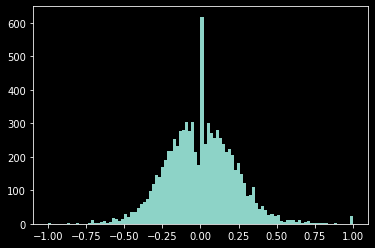

In [235]:
plt.figure()
plt.hist(all_nums, bins=100)
plt.show()

## Parse Term labels

In [285]:
# # parse states
# cleartext_states = []
# for l in [1,2,3]:
#     l_string = l_notation_switch(l).lower()
#     states = odict()
#     state_lines = open('./data/%s_states.txt' % l_string,'r').read().split('\n')
#     # duplicate_lines = open('./data/k_states_duplicate.txt','r').read().split('\n')
#     if l != 3:
#         for line_num, line in enumerate(state_lines):
#             if line == '':
#                 continue
#             if line[0] == '-':
#                 # parsing a new configuration
#                 num_electrons = int(line[2])
#                 lstr = line[1]
#                 l = l_notation_switch(line[1])
#                 states[(l, num_electrons)] = []
#             else:
#                 term_symbol = line.split(':')[0].upper()
#                 if len(term_symbol) == 3:
#                     term_idx = int(term_symbol[-1])
#                 else:
#                     term_idx = 1
#                 term_symbol = Term_label(sp.S(int(term_symbol[0])-1)/2, l_notation_switch(term_symbol[1]), term_idx)
#                 if lstr == 'p':
#                     γ= State_label(None, None)
#                 γ = line.split(':')[-1]
#                 γ = '%s(%s)' % (γ[0], γ[1:])
#                 γ = State_label(int(γ[0]), γ[1:])
#                 states[(l, num_electrons)].append((term_symbol, γ))
#                 if l_string == 'p':
#                     cleartext_states.append((l, num_electrons,'%d%s%d' % (term_symbol.S*2+1,l_notation_switch(term_symbol.L).upper(),term_symbol.W)))
#                 elif l_string == 'd':
#                     cleartext_states.append((l, num_electrons,'%d%s%d' % (term_symbol.S*2+1,l_notation_switch(term_symbol.L).upper(),term_symbol.W),
#                                                     γ.Seniority))
#     else:
#         for line_num, line in enumerate(state_lines):
#             if line == '':
#                 continue
#             if line[0] == '-':
#                 # parsing a new configuration
#                 num_electrons = int(line[2])
#                 lstr = line[1]
#                 l = l_notation_switch(line[1])
#                 states[(l, num_electrons)] = []
#             else:
#                 term_symbol = line.split(' ')[0].upper()
#                 if len(term_symbol) == 3:
#                     term_idx = int(term_symbol[-1])
#                 else:
#                     term_idx = 1
#                 term_symbol = Term_label(sp.S(int(term_symbol[0])-1)/2, l_notation_switch(term_symbol[1]), term_idx)
#                 if lstr == 'p':
#                     γ= State_label(None, None)
#                 γ = line.split(' ')[1:]
#                 γr = γ
#                 if len(γ) == 3:
#                     γ = '%s(%s)(%s)' % (γ[0], γ[1],γ[2])
#                 else:
#                     γ = '%s(%s)(%s)%s' % (γ[0], γ[1],γ[2],γ[3])
#                 γ = State_label(int(γ[0]), γ[1:])
#                 states[(l, num_electrons)].append((term_symbol, γ))

In [492]:
from collections import Counter
import pandas as pd
from fractions import Fraction

In [517]:
term_lines = open('./data/pdf_terms.txt','r').read().split('\n')
term_labels = odict()
s_Label = ntuple('d_Term',['l','n','label','multiS','L','idx','seniority','S'])
d_Label = ntuple('d_Term',['l','n','label','multiS','L','idx','seniority','R5','S'])
f_Label = ntuple('d_Term',['l','n','label','multiS','L','idx','seniority','R7','G2','variant','S'])
for line in term_lines:
    if line == '' or line[0] == '#':
        continue
    if line[0] == '-':
        l = l_notation_switch(line[1])
        n = int(line[2])
        term_labels[(l,n)] = []
        continue
    if l == 1:
        term_label = line.split(' ')[0]
        multiS = sp.S(int(line[0]))
        S = Fraction((multiS-1)/2)
        L = l_notation_switch(line[1])
        seniority = int(line.split(' ')[1])
        term_labels[(l,n)].append(s_Label(l,n,term_label,multiS,L,1,seniority,S))
        if len(term_label) == 3:
            print(line)
    elif l == 2:
        term_label = line.split(' ')[0]
        multiS = sp.S(int(line[0]))
        S = Fraction((multiS-1)/2)
        L = l_notation_switch(line[1])
        seniority = int(line.split(' ')[1])
        R5 = tuple(map(int,line.split(' ')[2]))
        if len(term_label) == 3:
            idx = int(term_label[2])
        else:
            idx = 1
        term_labels[(l,n)].append(d_Label(l,n,term_label,multiS,L,idx,seniority,R5,S))
    elif l == 3:
        term_label = line.split(' ')[0]
        multiS = sp.S(int(line[0]))
        S = Fraction((multiS-1)/2)
        L = l_notation_switch(line[1])
        seniority = int(line.split(' ')[1])
        R7 = tuple(map(int,line.split(' ')[2]))
        G2 = tuple(map(int,line.split(' ')[3]))
        if len(line.split(' ')) == 5:
            variant = line[-1]
        else:
            variant = 'A'
        if len(term_label) >= 3:
            idx = int(term_label[2:])
        else:
            idx = 1
        term_labels[(l,n)].append(f_Label(l,n,term_label,multiS,L,idx,seniority,R7,G2,variant,S))

sorted_term_labels = odict()
for k in term_labels:
    sorted_labels = list(sorted(term_labels[k], key=lambda x:x[5]))
    sorted_labels = list(sorted(sorted_labels, key=lambda x:x[4]))
    sorted_labels = list(sorted(sorted_labels, key=lambda x:x[3]))
    sorted_term_labels[k] = sorted_labels

dframes = [pd.DataFrame(list(map(lambda x: x._asdict(),sorted_term_labels[k]))) for k in sorted_term_labels]
termFrame = pd.concat(dframes).reset_index(drop=True)

rows = [x for x in zip(termFrame['l'], termFrame['n'], termFrame['multiS'], termFrame['L'],termFrame['R5'],termFrame['R7'], termFrame['G2'])]
counts = Counter([x for x in zip(termFrame['l'], termFrame['n'], termFrame['multiS'], termFrame['L'],termFrame['R5'],termFrame['R7'], termFrame['G2'])])
count_col = [counts[row] for row in rows]
termFrame['variants'] = count_col
termFrame['l^n'] = ['%s^%d' % (l_notation_switch(x),y) for x,y in zip(termFrame['l'],termFrame['n'])]

termFrame['multiL'] = [2*x+1 for x in termFrame['L']]
termFrame['multiLS'] = [x*y for x,y in zip(termFrame['multiS'],termFrame['multiL'])]
cols = 'l n l^n label S L idx multiS multiL multiLS seniority R5 R7 G2 variants variant'.split(' ')
termFrame = termFrame[cols]


In [520]:
termFrame

,l,n,l^n,label,S,L,idx,multiS,multiL,multiLS,seniority,R5,R7,G2,variants,variant
0,1,1,p^1,2P,1/2,1,1,2,3,6,1,NaN,NaN,NaN,1,NaN
1,1,2,p^2,1S,0,0,1,1,1,1,0,NaN,NaN,NaN,1,NaN
2,1,2,p^2,1D,0,2,1,1,5,5,2,NaN,NaN,NaN,1,NaN
3,1,2,p^2,3P,1,1,1,3,3,9,2,NaN,NaN,NaN,1,NaN
4,1,3,p^3,2P,1/2,1,1,2,3,6,1,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,3,7,f^7,6F,5/2,3,1,6,7,42,5,NaN,"(1, 1, 0)","(1, 0)",1,A
432,3,7,f^7,6G,5/2,4,1,6,9,54,7,NaN,"(2, 0, 0)","(2, 0)",1,A
433,3,7,f^7,6H,5/2,5,1,6,11,66,5,NaN,"(1, 1, 0)","(1, 1)",1,A
434,3,7,f^7,6I,5/2,6,1,6,13,78,7,NaN,"(2, 0, 0)","(2, 0)",1,A
